# 안개 발생 진단 분류 모델 생성

## 1. 데이터 설명

## 2. 데이터 불러오기

In [97]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import optuna
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("display.max_columns", None)

In [98]:
# def get_colab_path(train_dataset_name, test_dataset_name):

#     fog_folder = "drive/MyDrive/weather_bigdata/fog_data"
#     os.makedirs(fog_folder, exist_ok=True)

#     # train/test 데이터셋 경로 잡아준다
#     train_path = os.path.join(os.getcwd(), fog_folder, train_dataset_name)
#     test_path = os.path.join(os.getcwd(), fog_folder, test_dataset_name)

#     return train_path, test_path

In [275]:
def get_local_path(train_dataset_name, val_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    val_path = os.path.join(os.getcwd(), "fog_data", val_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        val_path = val_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_path, val_path, test_path

In [276]:
# 전처리 중간에 nan 제거해주고 이상치 처리한 데이터프레임
train_path, val_path, test_path = get_local_path(
    # "fog_train_merged_std.csv",
    # "fog_val_merged_std.csv", 
    # "fog_test_merged_std.csv"
    "fog_train_merged_month_stn_std.csv",
    "fog_val_merged_month_stn_std.csv",
    "fog_test_merged_month_stn_std.csv"
    )

In [277]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [278]:
train_df.shape, val_df.shape, test_df.shape

((2350456, 21), (783486, 21), (262800, 19))

In [279]:
# def make_categorical(df, col_list):

#     # class 컬럼 순서형 변수로 변경
#     for column in col_list:
#         if column in ["year", "month", "day", "time", "minute"]:
#             df[column] = pd.Categorical(df[column],
#                                         categories=np.unique(df[column]),
#                                         ordered=True)
#         else:
#             df[column] = pd.Categorical(df[column],
#                                         categories=np.unique(df[column]),
#                                         ordered=False)
#     return df

In [280]:
def make_str(df, col_list):
    for col in col_list:
        df[col] = df[col].astype("str")
    return df

In [281]:
# 범주형 변수들을 categorical_list에 선언

# month도 순서가 있기 때문에 ordinal
# https://wikidocs.net/161040#ordinal

categorical_list = ["year", "month", "day", "time", "minute", "stn_id", "re", "is_fog", "dew_reached", "ws10_dir", "class"]
train_df = make_str(train_df, categorical_list)
val_df = make_str(val_df, categorical_list)

# test 데이터셋에는 class 컬럼이 없기 때문에, class 컬럼을 삭제한다
categorical_list.pop()
test_df = make_str(test_df, categorical_list)

## 3. 모델링

### 3-1. 데이터 분리

In [282]:
# sun10_cond = (train_df["sun10"] >= 0.7)
# train_df.loc[sun10_cond, "sun10"] = 100

In [324]:
# target 컬럼
target = "class"

# # 모델 생성시 사용할 컬럼 지정
# used_cols = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm", 
#              "re", "ws10_ms", "sun10", "dew_reached", "ws10_deg"]

# 8방위 사용
used_cols = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm", 
             "re", "ws10_ms", "sun10", "dew_reached",  "t_td", "ws10_dir"]

# dew_reached 제거, 풍향 제거
# used_cols = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm", 
#              "re", "ws10_ms", "sun10"]

# 풍향 제거
# used_cols = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm", 
#              "re", "ws10_ms", "sun10", "dew_reached"]

X_train = train_df[used_cols]
y_train = train_df[target]

X_val = val_df[used_cols]
y_val = val_df[target]

X_test = test_df[used_cols]

In [325]:
X_train.head(3)

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_ms,sun10,dew_reached,t_td,ws10_dir
0,4,15,B,10.3,13.8,-3.5,59.3,0.0,2.2,0.14,0,7.340460,E
1,4,9,B,10.1,18.3,-8.2,54.4,0.0,4.8,0.31,0,8.496095,W
2,3,10,D,18.1,20.1,-2.0,47.0,0.0,3.1,0.22,0,11.129487,S


In [326]:
y_train.value_counts()

class
4    2326356
3       9135
2       9066
1       5899
Name: count, dtype: int64

In [327]:
y_val.value_counts()

class
4    775452
3      3045
2      3022
1      1967
Name: count, dtype: int64

#### 3-1-1. Train, Validation 데이터 분리

In [328]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((2350456, 13), (783486, 13), (2350456,), (783486,), (262800, 13))

In [329]:
X_train.head(3)

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_ms,sun10,dew_reached,t_td,ws10_dir
0,4,15,B,10.3,13.8,-3.5,59.3,0.0,2.2,0.14,0,7.340460,E
1,4,9,B,10.1,18.3,-8.2,54.4,0.0,4.8,0.31,0,8.496095,W
2,3,10,D,18.1,20.1,-2.0,47.0,0.0,3.1,0.22,0,11.129487,S


In [330]:
X_val.head(3)

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_ms,sun10,dew_reached,t_td,ws10_dir
0,3,8,B,4.2,5.7,-1.5,63.9,0.0,3.1,0.08,0,6.010578,W
1,2,7,D,-0.1,0.2,-0.3,93.5,0.0,5.0,0.00,0,0.888863,NW
2,4,3,A,6.7,4.2,2.5,46.2,0.0,0.1,0.00,0,10.387619,E


### 3-2. CSI 지수 생성

In [331]:
# CSI 지수 함수 생성
def csi_index(y_true, y_pred):

    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] +
            model_cm[1][0] + model_cm[1][2] +
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

csi_scorer = make_scorer(csi_index, greater_is_better=True)

### 3-3. 인코딩

#### 3-3-1. Label Encoding

In [332]:
# # Label Encoding 적용을 위해 train, val, test 데이터 copy()
# X_train_labeled = X_train.copy()
# X_val_labeled = X_val.copy()
# X_test_labeled = X_test.copy()

In [333]:
# # stn_id를 각각 1 ~ 5로 정한 딕셔너리 생성
# stn_id_map = {"A" : 1,
#               "B" : 2,
#               "C" : 3,
#               "D" : 4,
#               "E" : 5}

# # stn_id_map을 바탕으로 stn_id 컬럼 mapping
# X_train_labeled["stn_id"] = X_train_labeled["stn_id"].map(stn_id_map)
# X_val_labeled["stn_id"] = X_val_labeled["stn_id"].map(stn_id_map)
# X_test_labeled["stn_id"] = X_test_labeled["stn_id"].map(stn_id_map)

In [334]:
# # ws10_dir를 각각 1 ~ 5로 정한 딕셔너리 생성
# ws10_dir_map = {"N" : 1,
#               "NE" : 2,
#               "E" : 3,
#               "SE" : 4,
#               "S" : 5,
#               "SW" : 6,
#               "W" : 7,
#               "NW" : 8}

# # ws10_dir_map을 바탕으로 ws10_dir 컬럼 mapping
# X_train_labeled["ws10_dir"] = X_train_labeled["ws10_dir"].map(ws10_dir_map)
# X_val_labeled["ws10_dir"] = X_val_labeled["ws10_dir"].map(ws10_dir_map)
# X_test_labeled["ws10_dir"] = X_test_labeled["ws10_dir"].map(ws10_dir_map)

In [335]:
# def to_int(df, col_list):
#     for col in col_list:
#         df[col] = df[col].astype("int")
#     return df

In [336]:
# int_col_list = ["month", "day", "time", "minute", "re", "ws10_dir", "dew_reached"]
# X_train_labeled = to_int(X_train_labeled, int_col_list)
# X_val_labeled = to_int(X_val_labeled, int_col_list)
# X_test_labeled = to_int(X_test_labeled, int_col_list)

### 3-4. Baseline 모델 생성

In [337]:
# # 의사결정나무 모델로 Baseline 모델 생성
# dt = DecisionTreeClassifier(random_state=42)
# dt.fit(X_train_labeled, y_train)

### 3-5. 하이퍼 파라미터 튜닝 전 모델 생성 (CatBoost)

In [338]:
# X_train_no_enc = X_train.copy()
# X_val_no_enc = X_val.copy()

In [339]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350456 entries, 0 to 2350455
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   month        object 
 1   time         object 
 2   stn_id       object 
 3   ta           float64
 4   ts           float64
 5   temp_diff    float64
 6   hm           float64
 7   re           object 
 8   ws10_ms      float64
 9   sun10        float64
 10  dew_reached  object 
 11  t_td         float64
 12  ws10_dir     object 
dtypes: float64(7), object(6)
memory usage: 233.1+ MB


In [340]:
models = [
    # ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(
                                        loss_function='MultiClass', 
                                        # custom_metric=[CSIMetric()],
                                        # eval_metric=CSIMetric(),
                                        verbose=0, 
                                        task_type="GPU", 
                                        devices="0", 
                                        nan_mode="Max",
                                        random_state=42)
        ),
    ("CatBoost_FF", CatBoostClassifier(
                                        loss_function='MultiClass', 
                                        # custom_metric=[CSIMetric()],
                                        # eval_metric=CSIMetric(),
                                        verbose=0, 
                                        task_type="GPU", 
                                        devices="0", 
                                        simple_ctr="FeatureFreq",
                                        combinations_ctr="FeatureFreq",
                                        nan_mode="Max",
                                        random_state=42)
        ),
    # ("CatBoost_Buckets", CatBoostClassifier(
    #                                     loss_function='MultiClass', 
    #                                     # custom_metric=[CSIMetric()],
    #                                     # eval_metric=CSIMetric(),
    #                                     verbose=0, 
    #                                     task_type="GPU", 
    #                                     devices="0", 
    #                                     simple_ctr="Buckets",
    #                                     combinations_ctr="Buckets",
    #                                     nan_mode="Max",
    #                                     random_state=42)
    #     ),
]

cat_features = ["month", "time", "stn_id", "re", "dew_reached", "ws10_dir"]
# cat_features = ["month", "time", "stn_id", "re"]

In [341]:
X_train.head(3)

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_ms,sun10,dew_reached,t_td,ws10_dir
0,4,15,B,10.3,13.8,-3.5,59.3,0.0,2.2,0.14,0,7.340460,E
1,4,9,B,10.1,18.3,-8.2,54.4,0.0,4.8,0.31,0,8.496095,W
2,3,10,D,18.1,20.1,-2.0,47.0,0.0,3.1,0.22,0,11.129487,S


In [342]:
def model_comparison_cat(models, X_train, y_train, X_val, y_val, cat_features=cat_features, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        train_data = X_train
        eval_data = X_val

        train_label = y_train
        eval_label = y_val

        train_dataset = Pool(data=train_data,
                            label=train_label,
                            cat_features=cat_features)

        eval_dataset = Pool(data=eval_data,
                            label=eval_label,
                            cat_features=cat_features)

        # CatBoostClassifier
        model = model

        # 모델 생성 및 훈련
        model.fit(train_dataset)

        # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
        y_val_pred_cat = model.predict(eval_dataset)

        # 모델의 Accuracy, Precision, Recall, F1 score, CSI 지수 확인
        accuracy = accuracy_score(y_val, y_val_pred_cat)
        precision = precision_score(y_val, y_val_pred_cat, average="weighted")
        recall = recall_score(y_val, y_val_pred_cat, average="weighted")
        f1_score_ = f1_score(y_val, y_val_pred_cat, average="weighted")
        csi_index_ = csi_index(y_val, y_val_pred_cat)

        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                            "Accuracy" : np.round(accuracy, 4),
                            "Precision" : np.round(precision, 4),
                            "Recall" : np.round(recall, 4),
                            "F1 Score" : np.round(f1_score_, 4),
                            "CSI Index" : np.round(csi_index_, 4)
                            })

    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n======== Models {when} Hyper Parameter Tuning ========\n")

    return models_df.sort_values(by=["CSI Index", "Accuracy", "F1 Score"],
                                 ascending=[False, True, False]
                                 ).reset_index(drop=True)

In [343]:
model_comparison_cat(models, X_train, y_train, X_val, y_val)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost_FF,0.9911,0.9881,0.9911,0.9884,0.1678
1,CatBoost,0.9911,0.9879,0.9911,0.9884,0.1671


## 하이퍼파라미터 튜닝

In [344]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [372]:
def objective(trial, cat_features=cat_features):

    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        # "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 3, 12),
        # "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "simple_ctr" : trial.suggest_categorical("simple_ctr", [None, "FeatureFreq"]),
        "combinations_ctr" : trial.suggest_categorical("combinations_ctr", [None, "FeatureFreq"]),
        "bootstrap_type": "Bayesian",
        "loss_function": "MultiClass",
        "task_type": "GPU",
        "devices": "0",
        "nan_mode": "Max",
        "random_state": 42,
        "verbose" : False
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)


    cat_features = cat_features

    train_data = X_train
    eval_data = X_val

    train_label = y_train
    eval_label = y_val

    train_dataset = Pool(data=train_data,
                        label=train_label,
                        cat_features=cat_features)

    eval_dataset = Pool(data=eval_data,
                        label=eval_label,
                        cat_features=cat_features)

    gbm = CatBoostClassifier(**param)

    # pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    gbm.fit(
        train_dataset,
        verbose=0,
        # callbacks=[pruning_callback]
    )

    # evoke pruning manually.
    # pruning_callback.check_pruned()

    preds = gbm.predict(eval_dataset)
    csi = csi_index(y_val, preds)

    return csi

In [377]:
def objective_cat_no_enc(trial, cat_features=cat_features):
    params = {
        # "loss_function":'MultiClass',
        "iterations": trial.suggest_int("iterations", 100, 1000),
        # "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 3, 12),
        # "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        # "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        # "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        # "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "simple_ctr" : trial.suggest_categorical("simple_ctr", [None, "FeatureFreq"]),
        "combinations_ctr" : trial.suggest_categorical("combinations_ctr", [None, "FeatureFreq"]),
        # "verbose": False
        # "loss_function": trial.suggest_categorical("loss_function", ["MultiClass"]),
        "bootstrap_type": "Bayesian",
        "loss_function": "MultiClass",
        # "task_type": trial.suggest_categorical("task_type", ["GPU"]),
        "task_type": "GPU",
        "devices": "0",
        "nan_mode": "Max",
        # "random_state":trial.suggest_int("random_state", 42, 42)
        "random_state": 42,
        "verbose" : False
    }

    cat_features = cat_features

    train_data = X_train
    eval_data = X_val

    train_label = y_train
    eval_label = y_val

    train_dataset = Pool(data=train_data,
                        label=train_label,
                        cat_features=cat_features)

    eval_dataset = Pool(data=eval_data,
                        label=eval_label,
                        cat_features=cat_features)

    model = CatBoostClassifier(**params)
                            #    loss_function="MultiClass",
                            #    silent=True,
                            #    task_type="GPU",
                            #    random_state=42)

    model.fit(train_dataset)
    predictions = model.predict(eval_dataset)
    csi = csi_index(y_val, predictions)

    return csi

In [374]:
# study_cat_no_enc = optuna.create_study(study_name="catboost_no_enc", direction='maximize', pruner="HyperbandPruner", sampler=sampler)
# study_cat_no_enc.optimize(objective_cat_no_enc, n_trials=100)

In [378]:
study_cat = optuna.create_study(study_name="catboost", direction='maximize', pruner="HyperbandPruner", sampler=sampler)
study_cat.optimize(objective_cat_no_enc, n_trials=100)

[I 2024-06-27 14:45:44,240] A new study created in memory with name: catboost
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
[I 2024-06-27 14:47:07,989] Trial 0 finished with value: 0.08847711375628911 and parameters: {'iterations': 834, 'learning_rate': 0.025924756604751596, 'depth': 10, 'bagging_temperature': 0.7712703466859457, 'od_wait': 13, 'min_data_in_leaf': 36, 'simple_ctr': 'FeatureFreq', 'combinations_ctr': None}. Best is trial 0 with value: 0.08847711375628911.
Change of combinations ctrs will not affect simple ctrs
Change of combinations ctrs will not affect simple ctrs
Change of combinations ctrs will not affect simple ctrs
Change of combinations ctrs will not affect simple ctrs
[I 2024-06-27 14:47:30,755] Trial 1 finished with value: 0.0 and parameters: {'iterations': 157, 'learning_rate': 0.0041875947

In [ ]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best CSI Index:", study_cat.best_value, sep="\n")

In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [ ]:
# 하이퍼파라미터 튜닝을 통해 나온 최적의 하이퍼 파라미터 best_params에 선언
best_params_no_enc = study_cat.best_params

In [ ]:
best_params_no_enc

In [ ]:
# 모델 비교

models_tuned = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(**params_dict)),
    ("CatBoost_tuned", cat_optuna),
    ("CatBoost_tuned_no_enc", cat_optuna_no_enc),
]

In [ ]:
# 학습
cat_optuna_no_enc.fit(X_train_no_enc, y_train, cat_features=cat_features)

### 3-6. 모델 학습 (CatBoost)

In [49]:
train_data = X_train
eval_data = X_val

cat_features = cat_features

train_label = y_train
eval_label = y_val

train_dataset = Pool(data=train_data,
                    label=train_label,
                    cat_features=cat_features)

eval_dataset = Pool(data=eval_data,
                    label=eval_label,
                    cat_features=cat_features)

In [50]:
eval_dataset

In [510]:
cat_no_enc = CatBoostClassifier(loss_function='MultiClass', 
                                verbose=0, 
                                task_type="GPU",
                                devices="0",
                                random_state=42)

cat_no_enc.fit(train_dataset)

In [511]:
y_val_pred_cat = cat_no_enc.predict(eval_dataset)

In [512]:
cat_cm = confusion_matrix(y_val, y_val_pred_cat)
print(cat_cm)

csi_cat = csi_index(y_val, y_val_pred_cat)
csi_cat

[[   705    206     10   1046]
 [   167    826     90   1939]
 [    40    211    228   2566]
 [    68    166    112 775106]]


0.20990453460620526

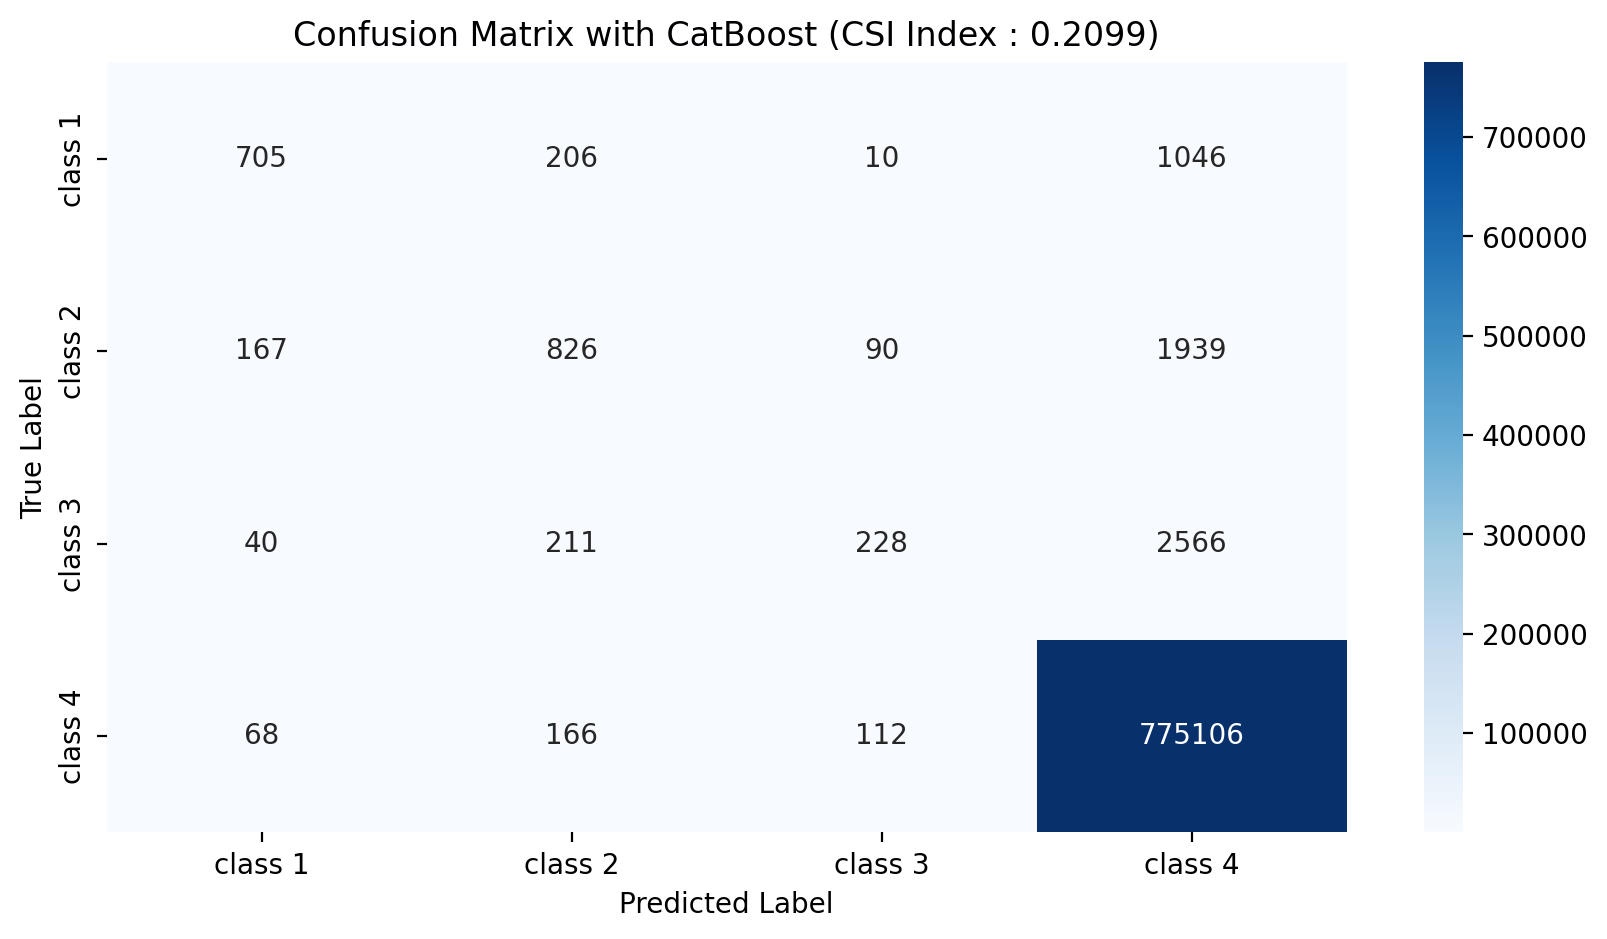

In [513]:
# Confusion Matrix 시각화

plt.figure(figsize=(10,5))

# target 컬럼 값들 unique_value에 선언
unique_value = np.unique(y_val_pred_cat, return_counts = False)

# Confusion Matrix에 label 표시하기 위해 "class" + value 합쳐준다
unique_value_list = []
for i, value in enumerate(unique_value):
    unique_value_list.append("class " + str(int(value)))


pred_labels = unique_value_list
sns.heatmap(cat_cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            xticklabels = pred_labels, 
            yticklabels = pred_labels)

plt.title(f'Confusion Matrix with CatBoost (CSI Index : {np.round(csi_cat, 4)})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 4. 하이퍼 파라미터 튜닝

#### 4-1. CatBoost 튜닝

In [318]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [331]:
# https://practicaldatascience.co.uk/machine-learning/how-to-tune-a-catboostclassifier-model-with-optuna
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#configurations
# https://catboost.ai/en/docs/concepts/parameter-tuning#methods-for-hyperparameter-search-by-optuna

def objective_cat(trial):
    params = {
        # "loss_function":'MultiClass',
        "iterations": trial.suggest_int("iterations", 100, 1000),
        # "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        # "verbose": False
        # "loss_function": trial.suggest_categorical("loss_function", ["MultiClass"]),
        "loss_function": "MultiClass",
        # "task_type": trial.suggest_categorical("task_type", ["GPU"]),
        "task_type": "GPU",
        # "random_state":trial.suggest_int("random_state", 42, 42)
        "random_state": 42,
        "verbose" : False
    }

    model = CatBoostClassifier(**params
                            #    loss_function="MultiClass",
                               )
                            #    task_type="GPU",
                            #    random_state=42)

    model.fit(X_train_labeled, y_train)
    predictions = model.predict(X_val_labeled)
    csi = csi_index(y_val, predictions)

    return csi

In [332]:
study_cat = optuna.create_study(study_name="catboost", direction='maximize', pruner="HyperbandPruner", sampler=sampler)
study_cat.optimize(objective_cat, n_trials=100)

[I 2024-06-24 21:59:40,509] A new study created in memory with name: catboost
[I 2024-06-24 21:59:47,281] Trial 0 finished with value: 0.0 and parameters: {'iterations': 850, 'learning_rate': 0.0026587543983272706, 'depth': 4, 'l2_leaf_reg': 6.8240955406304e-07, 'bootstrap_type': 'Poisson', 'random_strength': 7.71800699380605e-05, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'min_data_in_leaf': 37}. Best is trial 0 with value: 0.0.
[I 2024-06-24 21:59:58,284] Trial 1 finished with value: 0.0205579058699101 and parameters: {'iterations': 510, 'learning_rate': 0.037183641805732096, 'depth': 4, 'l2_leaf_reg': 0.0013878559259972313, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0029369981104377003, 'bagging_temperature': 0.17052412368729153, 'od_type': 'Iter', 'od_wait': 49, 'min_data_in_leaf': 81}. Best is trial 1 with value: 0.0205579058699101.
[I 2024-06-24 22:00:02,029] Trial 2 finished with value: 0.0 and parameters: {'iterations': 374, 'learni

KeyboardInterrupt: 

In [ ]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best CSI Index:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'iterations': 847, 'learning_rate': 0.09884590626951238, 'depth': 10, 'l2_leaf_reg': 0.05525462311307756, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0008044769106469332, 'bagging_temperature': 0.8651534530853479, 'od_type': 'IncToDec', 'od_wait': 37, 'min_data_in_leaf': 54, 'loss_function': 'MultiClass', 'task_type': 'GPU', 'random_state': 42}
-----------------------------------------------------------------------------------------------------------------
Best CSI Index:
0.24231918708906156


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [ ]:
# 하이퍼파라미터 튜닝을 통해 나온 최적의 하이퍼 파라미터 best_params에 선언
best_params = study_cat.best_params

In [ ]:
# CatBoost 모델을 돌릴 때 추가로 설정해주는 하이퍼파라미터
params_dict = {"loss_function" : "MultiClass",
               "verbose" : 0,
               "task_type" : "GPU",
               "devices" : "0",
               "random_state" : 42}

In [80]:
# best_params에 params_dict을 합쳐준다
def params(params):

    params_dict = {"loss_function" : "MultiClass",
                   "verbose" : 0,
                   "task_type" : "GPU",
                   "devices" : "0",
                   "random_state" : 42}
    
    for key, value in params_dict.items():
        params[key] = value
    
    return params

In [81]:
params(best_params)

{'iterations': 969,
 'learning_rate': 0.0878195653278425,
 'depth': 10,
 'l2_leaf_reg': 0.11654433378634937,
 'bootstrap_type': 'Bayesian',
 'random_strength': 1.3986307347140839e-06,
 'bagging_temperature': 0.5870994114781527,
 'od_type': 'IncToDec',
 'od_wait': 23,
 'min_data_in_leaf': 9,
 'loss_function': 'MultiClass',
 'verbose': 0,
 'task_type': 'GPU',
 'devices': '0',
 'random_state': 42}

In [83]:
# 튜닝한 하이퍼 파라미터를 바탕으로, CatBoostClassifier 선언
cat_optuna = CatBoostClassifier(**params(best_params))

In [85]:
cat_optuna.get_params()

{'iterations': 969,
 'learning_rate': 0.0878195653278425,
 'depth': 10,
 'l2_leaf_reg': 0.11654433378634937,
 'loss_function': 'MultiClass',
 'od_wait': 23,
 'od_type': 'IncToDec',
 'verbose': 0,
 'random_strength': 1.3986307347140839e-06,
 'bagging_temperature': 0.5870994114781527,
 'task_type': 'GPU',
 'devices': '0',
 'bootstrap_type': 'Bayesian',
 'random_state': 42,
 'min_data_in_leaf': 9}

#### 4-2. CatBoost 인코딩 X

In [134]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [1]:
def objective_cat_no_enc(trial, cat_features=cat_features):
    params = {
        # "loss_function":'MultiClass',
        "iterations": trial.suggest_int("iterations", 100, 1000),
        # "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        # "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        # "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        # "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "simple_ctr" : trial.suggest_categorical("simple_ctr", [None, "FeatureFreq", "Buckets"]),
        "combinations_ctr" : trial.suggest_categorical("combinations_ctr", [None, "FeatureFreq", "Buckets"]),
        # "verbose": False
        # "loss_function": trial.suggest_categorical("loss_function", ["MultiClass"]),
        "loss_function": "MultiClass",
        # "task_type": trial.suggest_categorical("task_type", ["GPU"]),
        "task_type": "GPU",
        # "random_state":trial.suggest_int("random_state", 42, 42)
        "random_state": 42,
        "verbose" : False
    }

    cat_features = cat_features

    train_data = X_train_no_enc
    eval_data = X_val_no_enc

    train_label = y_train
    eval_label = y_val

    train_dataset = Pool(data=train_data,
                        label=train_label,
                        cat_features=cat_features)

    eval_dataset = Pool(data=eval_data,
                        label=eval_label,
                        cat_features=cat_features)

    model = CatBoostClassifier(**params)
                            #    loss_function="MultiClass",
                            #    silent=True,
                            #    task_type="GPU",
                            #    random_state=42)

    model.fit(train_dataset)
    predictions = model.predict(eval_dataset)
    csi = csi_index(y_val, predictions)

    return csi

NameError: name 'cat_features' is not defined

In [141]:
study_cat_no_enc = optuna.create_study(study_name="catboost_no_enc", direction='maximize', pruner="HyperbandPruner", sampler=sampler)
study_cat_no_enc.optimize(objective_cat_no_enc, n_trials=100)

[I 2024-06-26 23:11:58,164] A new study created in memory with name: catboost_no_enc
[I 2024-06-26 23:12:40,276] Trial 0 finished with value: 0.00422360248447205 and parameters: {'iterations': 807, 'learning_rate': 0.002508115686045232, 'depth': 7, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6075448519014384, 'od_wait': 16, 'min_data_in_leaf': 7, 'simple_ctr': 'FeatureFreq', 'combinations_ctr': 'Buckets'}. Best is trial 0 with value: 0.00422360248447205.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
[I 2024-06-26 23:12:51,093] Trial 1 finished with value: 0.0 and parameters: {'iterations': 496, 'learning_rate': 0.0017541893487450805, 'depth': 6, 'bootstrap_type': 'Poisson', 'bagging_temperature': 0.2587799816000169, 'od_wait': 37, 'min_data_in_leaf': 32, 'simple_ctr': 'FeatureFreq', 'combinations_ctr': N

In [142]:
print("Best hyperparameters:", study_cat_no_enc.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best CSI Index:", study_cat_no_enc.best_value, sep="\n")

Best hyperparameters:
{'iterations': 902, 'learning_rate': 0.09892754692258024, 'depth': 10, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.28979194050830664, 'od_wait': 10, 'min_data_in_leaf': 78, 'simple_ctr': None, 'combinations_ctr': 'FeatureFreq'}
-----------------------------------------------------------------------------------------------------------------
Best CSI Index:
0.19711365003006615


In [150]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat_no_enc)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [combinations_ctr (CategoricalDistribution):
                                0.003271696619148365<extra></extra>, od_wait
                                (IntDistribution):
                                0.004440799968081603<extra></extra>,
                                bagging_temperature (FloatDistribution):
                                0.004878026057178792<extra></extra>,
                                min_data_in_leaf (IntDistribution):
                                0.01848430627699678<extra></extra>, depth
                                (IntDistribution):
                                0.0241353051620846<extra></extra>, simple_ctr
                                (CategoricalDistribution):
                                0.024264439950968157<extra></extra>, iterations
                                (IntDistribution):
                                0.036231346987425105<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.21681863345994146<extra></extra>, bootstrap_type
                                (CategoricalDistribution):
                                0.6674754455181752<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, <0.01, 0.02, 0.02, 0.02, 0.04, 0.22, 0.67],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.003271696619148365, 0.004440799968081603,
                    0.004878026057178792, 0.01848430627699678, 0.0241353051620846,
                    0.024264439950968157, 0.036231346987425105,
                    0.21681863345994146, 0.6674754455181752],
              'y': [combinations_ctr, od_wait, bagging_temperature,
                    min_data_in_leaf, depth, simple_ctr, iterations, learning_rate,
                    bootstrap_type]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [148]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat_no_enc)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.00422360248447205, 0.0, 0.0, 0.007199602780536246, 0.0, 0.0,
                    0.0, 0.0, 0.017559045381476443, 0.0, 0.09782608695652174,
                    0.1316461856673561, 0.13215109923478682, 0.164166465037503,
                    0.1483050847457627, 0.17001452081316554, 0.05815950920245399,
                    0.1532864419112297, 0.08024464831804282, 0.04022072348252606,
                    0.028683500858053445, 0.15183881539021726, 0.14112365004247057,
                    0.09341799975576993, 0.16990701606086223, 0.10298598415600244,
                    0.0, 0.0780523611450942, 0.030797546012269937,
                    0.1276621638067421, 0.0329036218538981, 0.14731980065637534,
                    0.1205742791093807, 0.17679024272430865, 0.0,
                    0.16942998910807214, 0.0, 0.12143379663496708, 0.0,
                    0.04003930238270695, 0.04458364038319823, 0.17528631705846895,
                    0.14786936991623165, 0.15722431153706176, 0.14915048543689322,
                    0.12262542620555285, 0.0, 0.1161714564052606,
                    0.16880290205562273, 0.029757531227038943,
                    0.009297136481963555, 0.16741260433047053, 0.1733558994197292,
                    0.16803675048355898, 0.15272550685929343, 0.06582957454589784,
                    0.06097710297538876, 0.009429280397022333, 0.0902641878669276,
                    0.0, 0.08861222995239838, 0.1619590253364044,
                    0.1553727008712488, 0.16310938636914868, 0.18853150222864715,
                    0.17038023734560426, 0.1109082055028001, 0.09165758566412399,
                    0.020221948212083847, 0.1744017403915881, 0.1402187120291616,
                    0.1787991818072434, 0.17684693384838243, 0.1748792270531401,
                    0.13464576497751854, 0.17164269309802974, 0.14817509397356615,
                    0.0, 0.10045160502868303, 0.1558944565480513,
                    0.11895185862279098, 0.17347185310461463, 0.16569767441860464,
                    0.1540140674266311, 0.008677327383165985, 0.13720732742933398,
                    0.07210834553440702, 0.10754257907542579, 0.19711365003006615,
                    0.0, 0.15241906147690068, 0.1832005792903693,
                    0.14141904184354154, 0.18002421307506053, 0.16420261754726126,
                    0.1726844583987441, 0.16291727140783743, 0.18263075250634134,
                    0.19048192771084338, 0.17869665094909926]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.00422360248447205, 0.00422360248447205, 0.00422360248447205,
                    0.007199602780536246, 0.007199602780536246,
                    0.007199602780536246, 0.007199602780536246,
                    0.0

In [145]:
# 하이퍼파라미터 튜닝을 통해 나온 최적의 하이퍼 파라미터 best_params에 선언
best_params_no_enc = study_cat_no_enc.best_params

In [146]:
best_params_no_enc

{'iterations': 902,
 'learning_rate': 0.09892754692258024,
 'depth': 10,
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 0.28979194050830664,
 'od_wait': 10,
 'min_data_in_leaf': 78,
 'simple_ctr': None,
 'combinations_ctr': 'FeatureFreq'}

In [116]:
# 튜닝한 하이퍼 파라미터를 바탕으로, CatBoostClassifier 선언
# cat_optuna_no_enc = CatBoostClassifier(**params(best_params_no_enc))
best_params_no_enc = {'iterations': 969, 
                      'learning_rate': 0.09185833755448329, 
                      'depth': 10, 
                      'bootstrap_type': 'Bayesian', 
                      'bagging_temperature': 0.5563853663136828, 
                      'od_wait': 12, 
                      'min_data_in_leaf': 73,
                      "loss_function" : "MultiClass",
                      "verbose" : 0,
                      "task_type" : "GPU",
                      "devices" : "0",
                      "random_state" : 42}

cat_optuna_no_enc = CatBoostClassifier(**best_params_no_enc)

In [117]:
cat_optuna_no_enc.get_params()

{'iterations': 969,
 'learning_rate': 0.09185833755448329,
 'depth': 10,
 'loss_function': 'MultiClass',
 'od_wait': 12,
 'verbose': 0,
 'bagging_temperature': 0.5563853663136828,
 'task_type': 'GPU',
 'devices': '0',
 'bootstrap_type': 'Bayesian',
 'random_state': 42,
 'min_data_in_leaf': 73}

#### 4-3. 모델 비교

In [188]:

models_tuned = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(**params_dict)),
    ("CatBoost_tuned", cat_optuna),
    ("CatBoost_tuned_no_enc", cat_optuna_no_enc),
]

In [189]:
model_comparison_cat(models_tuned, X_train_labeled, y_train, X_val_labeled, y_val, when="After")


======== Models After Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost_tuned_no_enc,0.9917,0.9893,0.9917,0.9897,0.2585
1,CatBoost_tuned,0.9917,0.9892,0.9917,0.9896,0.2516
2,Decision Tree,0.9875,0.9884,0.9875,0.9879,0.2378
3,CatBoost,0.9911,0.9881,0.9911,0.9885,0.1947


#### 4-4. 튜닝한 모델 학습 (인코딩 X)

In [118]:
cat_optuna_no_enc.fit(X_train_no_enc, y_train, cat_features=cat_features)

In [119]:
y_val_pred_no_enc = cat_optuna_no_enc.predict(X_val_no_enc)

In [120]:
cat_cm = confusion_matrix(y_val, y_val_pred_no_enc)
print(cat_cm)

csi_cat = csi_index(y_val, y_val_pred_no_enc)
csi_cat

[[   788    229     12    938]
 [   192    898     96   1836]
 [    27    215    282   2521]
 [    40    140     97 775175]]


0.23679460955360365

In [121]:
# y_val_pred_no_enc = cat_optuna_no_enc.predict(X_val)

In [122]:
# cat_cm_no_enc = confusion_matrix(y_val, y_val_pred_no_enc)
# print(cat_cm_no_enc)

# csi_cat_no_enc = csi_index(y_val, y_val_pred_no_enc)
# # csi_cat_no_enc

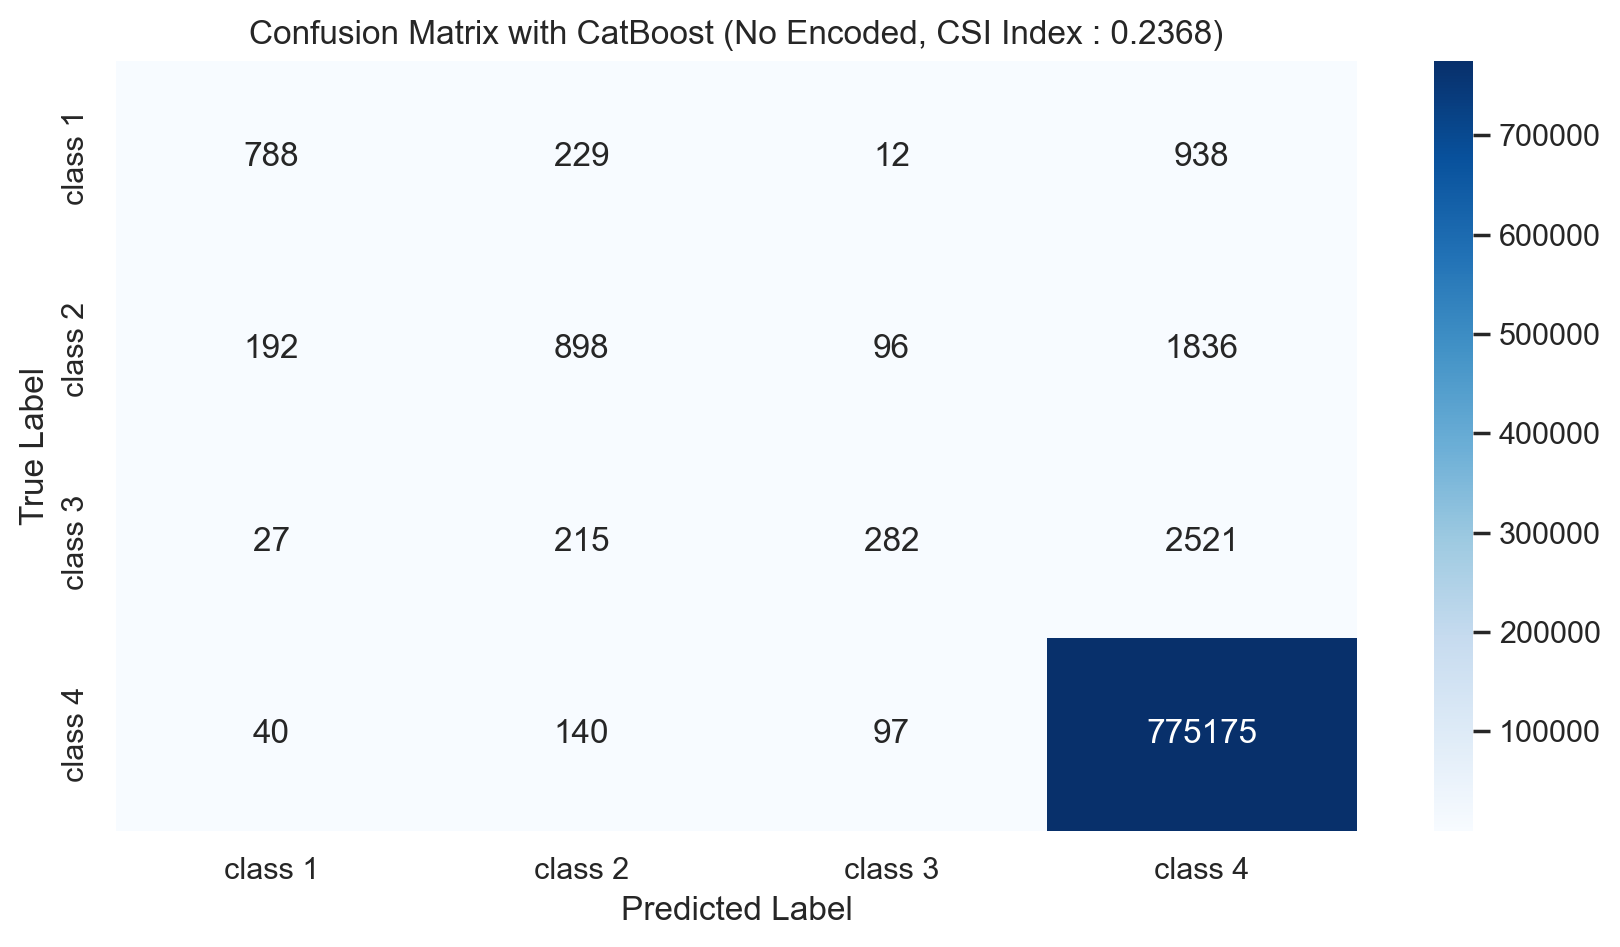

In [123]:
# Confusion Matrix 시각화

plt.figure(figsize=(10,5))

# target 컬럼 값들 unique_value에 선언
unique_value = np.unique(y_val_pred_no_enc, return_counts = False)

# Confusion Matrix에 label 표시하기 위해 "class" + value 합쳐준다
unique_value_list = []
for i, value in enumerate(unique_value):
    unique_value_list.append("class " + str(int(value)))


pred_labels = unique_value_list
sns.heatmap(cat_cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            xticklabels = pred_labels, 
            yticklabels = pred_labels)

plt.title(f'Confusion Matrix with CatBoost (No Encoded, CSI Index : {np.round(csi_cat, 4)})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### 4-5. 모델 저장 (pickle)

In [117]:
# 전처리 마친 데이터셋 저장할 경로 설정하는 함수

def save_pickle_path(model_name):
        
    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # pickle 저장 이름 설정
    save_pickle = model_name + ".pkl"
    # 전처리 거친 데이터셋 저장 경로 설정
    pickle_save_path = os.path.join(os.getcwd(), "fog_data", save_pickle)
    
    
    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        pickle_save_path = pickle_save_path.replace("\\", "/")

    # # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return pickle_save_path

In [104]:
save_pickle_path("cat_optuna")

'c:/Users/aryij/Documents/DataStudy/fog_data/cat_optuna.pkl'

In [124]:
save_pickle_path("cat_optuna_no_enc")

NameError: name 'save_pickle_path' is not defined

In [105]:
# 하이퍼파라미터 튜닝 거친 모델 pickle 저장
with open(file=save_pickle_path("cat_optuna"), mode='wb') as f:
    pickle.dump(cat_optuna, f)

In [119]:
# 하이퍼파라미터 튜닝 거친 모델 pickle 저장
with open(file=save_pickle_path("cat_optuna_no_enc"), mode='wb') as f:
    pickle.dump(cat_optuna_no_enc, f)

In [107]:
# pickle로 저장한 모델 불러오기
with open(file=save_pickle_path("cat_optuna"), mode="rb") as f:
    # loaded_model 이라는 이름에 모델 불러온다
    loaded_model = pickle.load(f)

In [121]:
X_train_no_enc

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_deg,ws10_ms,sun10,dew_reached
0,4,15,B,10.3,13.8,-3.5,59.3,0,112.4,2.2,0.14,0
1,4,9,B,10.1,18.3,-8.2,54.4,0,273.6,4.8,0.31,0
2,3,10,D,18.1,20.1,-2.0,47.0,0,158.2,3.1,0.22,0
3,7,23,A,24.0,24.3,-0.3,81.8,0,238.0,0.9,0.00,0
4,1,0,D,-3.8,-3.0,-0.8,81.6,0,303.7,1.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2210951,3,15,A,3.7,9.2,-5.5,50.9,0,291.9,4.7,0.06,0
2210952,3,0,A,10.4,7.2,3.2,64.0,0,120.0,1.2,0.00,0
2210953,8,2,D,25.4,25.3,0.1,92.7,0,239.4,3.4,0.00,0
2210954,11,21,A,11.4,5.5,5.9,83.4,0,184.6,0.7,0.00,1


In [120]:
X_test

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_deg,ws10_ms,sun10,dew_reached
0,1,0,A,-2.5,-1.6,-0.9,87.5,0,329.5,0.6,0.0,0
1,1,0,A,-2.5,-1.6,-0.9,88.2,0,321.8,1.2,0.0,0
2,1,0,A,-2.5,-1.7,-0.8,88.6,0,0.4,0.4,0.0,0
3,1,0,A,-2.6,-1.6,-1.0,88.7,0,323.6,0.7,0.0,0
4,1,0,A,-2.6,-1.6,-1.0,89.0,0,208.4,0.2,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
262795,12,23,E,4.5,1.9,2.6,71.3,0,338.8,6.1,0.0,0
262796,12,23,E,4.6,1.9,2.7,71.4,0,335.2,5.8,0.0,0
262797,12,23,E,4.5,1.8,2.7,72.1,0,337.1,5.3,0.0,0
262798,12,23,E,4.3,1.4,2.9,72.5,0,322.0,3.7,0.0,0


In [125]:
y_test_pred = cat_optuna_no_enc.predict(X_test)

In [126]:
y_test_pred_df = pd.DataFrame(y_test_pred)

In [127]:
y_test_pred_df.to_csv("C:/Users/aryij/Documents/DataStudy/weather-contest/data/y_test_pred_df_many_rows.csv")